<font color='darkblue'>
    
</font>

In [76]:
# Imports
import networkx as nx
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import urllib.request
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import io
from wordcloud import WordCloud
from collections import defaultdict
import math

# Assignment 2

## Part 0: Building the network

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

- Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.


- Show the regular expression(s) you have built and explain in details how it works.

## Part 1: Network visualization and basic stats

In [13]:
#Building the network from the .txt files
failed = ['Granté','Metal Boulder','Spiked Boulder','Central Hy'] #Characters that I failed to retrive info on
charactersDf = pd.read_csv('charecters.csv')


In [14]:
def nodeInfo(text):
    genderRe1 = re.findall(r'(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)?(?:\{\{.*?\}\})?',text)
    if genderRe1:
        if genderRe1[0] == '':
            gender = 'Unknown'
        else:
            gender = genderRe1[0]
    else:
        gender = 'Unknown'
    raceRe1 = re.findall(r'(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}',text)
    raceRe2 = re.findall(r'(?:race=\s)\[\[(.*?)(?:\|.*?)?\]\]',text)

    if raceRe1:
        race = raceRe1[0]
    elif raceRe2:
        race = raceRe2[0] 
    else:
        race = 'none'
    pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
    pattern2 = '\{\{Term\|BotW\|(.*?)\|link\}\}'
    square = re.findall(pattern1,text)
    curly = re.findall(pattern2,text)
    edges = square + curly
    return gender,race,edges

In [15]:
def filterC(chars,charList):
    ret = []
    i = 0
    for i in range(len(chars)):
        if chars[i] in charList:
            ret.append(chars[i])
    return ret

In [16]:
def tuples(name, list):
    tmp = []
    for item in list:
        tmp.append((name,item))
    return tmp

In [23]:
nameList = list(charactersDf.Name)
networkInfoDf = pd.DataFrame(columns={"name","race","gender","charlist",'role'})
for row in charactersDf.iterrows():
    try:
        name= row[1]['Name']
        with open("utf8txtfiles/" + name + '.txt',encoding='utf-8') as f:
            text = f.read()
        g,r,e = nodeInfo(text)
        charList = filterC(e,nameList)
        networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    except:
        print(name)
    
    


Granté
Magma Bomb
Metal Boulder


In [24]:
G = nx.DiGraph()
nameList = list(charactersDf.Name)
#Add all nodes to graph
for row in networkInfoDf.iterrows():
    name = row[1]['name']
    gender = row[1]['gender']
    race = row[1]['race']
    role = row[1]['role']
    G.add_node(name,race = race, gender = gender,role=role)

for row in networkInfoDf.iterrows():
    charList = row[1]['charlist']
    G.add_edges_from(charList)

- What is the number of nodes in the network?
- More importantly, what is the number of links?

In [25]:
GunD = G.to_undirected()
giant = list(max(nx.connected_components(GunD), key=len))
gcc = G.subgraph(giant).copy()
print('Number of nodes and links in the network')
print('------------------------------------------')
print(nx.info(gcc))

Number of nodes and links in the network
------------------------------------------
Name: 
Type: DiGraph
Number of nodes: 528
Number of edges: 1478
Average in degree:   2.7992
Average out degree:   2.7992


- Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [26]:
AllyInDegree = []
AllyOutDegree = []
AllyTotalDegree = []

EnemyInDegree = []
EnemyOutDegree = []
EnemyTotalDegree = []
for node in gcc.nodes(data=True):
    if bool(node[1]):
        if node[1]['role'] == 'Ally':
            AllyInDegree.append((node[0],gcc.in_degree(node[0])))
            AllyOutDegree.append((node[0],gcc.out_degree(node[0])))
            AllyTotalDegree.append((node[0],gcc.degree(node[0])))
        else:
            EnemyInDegree.append((node[0],gcc.in_degree(node[0])))
            EnemyOutDegree.append((node[0],gcc.out_degree(node[0])))
            EnemyTotalDegree.append((node[0],gcc.degree(node[0])))

inDegree = [(node,G.in_degree(node)) for node in G.nodes()]
outDegree = [(node,G.out_degree(node)) for node in G.nodes()]
totalDegree = [(node,G.degree(node)) for node in G.nodes()]
print( 'The charecter with the highest \'in\' degree is: ',max(inDegree,key=lambda item:item[1])[0])
print( 'The charecter with the highest \'out\' degree is: ',max(outDegree,key=lambda item:item[1])[0])
print( 'The charecter with the highest \'total\' degree is: ',max(totalDegree,key=lambda item:item[1])[0])

The charecter with the highest 'in' degree is:  Link
The charecter with the highest 'out' degree is:  Traysi
The charecter with the highest 'total' degree is:  Link


As expected, the main character of the series, Link, is the most connected character in terms of 'in' degree and in the undirected graph. As the others of this report are not totally familiar with the Zelda games, we are not familiar with the character Traysi, so we can't really comment on that.

- Who are the top 5 most connected allies (again in terms of in/out-degree)?


In [27]:
AllyInDegree.sort(key=lambda y: y[1],reverse=True)
AllyOutDegree.sort(key=lambda y: y[1],reverse=True)
AllyTotalDegree.sort(key=lambda y: y[1],reverse=True)

EnemyInDegree.sort(key=lambda y: y[1],reverse=True)
EnemyOutDegree.sort(key=lambda y: y[1],reverse=True)
EnemyTotalDegree.sort(key=lambda y: y[1],reverse=True)
print("The allies with the highest in degree are:")
for i in range (5):
    print(AllyInDegree[i])
print('----------------------------')
print("The allies with the highest out degree are:")
for i in range (5):
    print(AllyOutDegree[i])
print('----------------------------')
print("The top 5 most connected allies are:")
for i in range (5):
    print(AllyTotalDegree[i])

The allies with the highest in degree are:
('Link', 377)
('Riju', 22)
('Princess Zelda', 19)
('Mipha', 18)
('Sidon', 13)
----------------------------
The allies with the highest out degree are:
('Traysi', 14)
('Urbosa', 11)
('Link', 10)
('Daruk', 9)
('Impa', 9)
----------------------------
The top 5 most connected allies are:
('Link', 387)
('Princess Zelda', 27)
('Riju', 27)
('Mipha', 25)
('Impa', 21)


- Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?


In [28]:
print("The enemies with the highest in degree are:")
for i in range (5):
    print(EnemyInDegree[i])
print('----------------------------')
print("The enemies with the highest out degree are:")
for i in range (5):
    print(EnemyOutDegree[i])
print('----------------------------')
print("The top 5 most connected enemies are:")
for i in range (5):
    print(EnemyTotalDegree[i])

The enemies with the highest in degree are:
('Calamity Ganon', 86)
('Gerudo Desert', 55)
('Bokoblin', 11)
('Malice', 9)
('Moblin', 8)
----------------------------
The enemies with the highest out degree are:
('Stalizalfos', 11)
('Moblin', 10)
('Silver Lizalfos', 9)
('Gerudo Desert', 9)
('Blue Lizalfos', 8)
----------------------------
The top 5 most connected enemies are:
('Calamity Ganon', 91)
('Gerudo Desert', 64)
('Moblin', 18)
('Stalizalfos', 18)
('Silver Lizalfos', 13)


- Plot the in- and out-degree distributions. 
- - What do you observe? 
- - Can you explain why the in-degree distribution is different from the out-degree distribution?

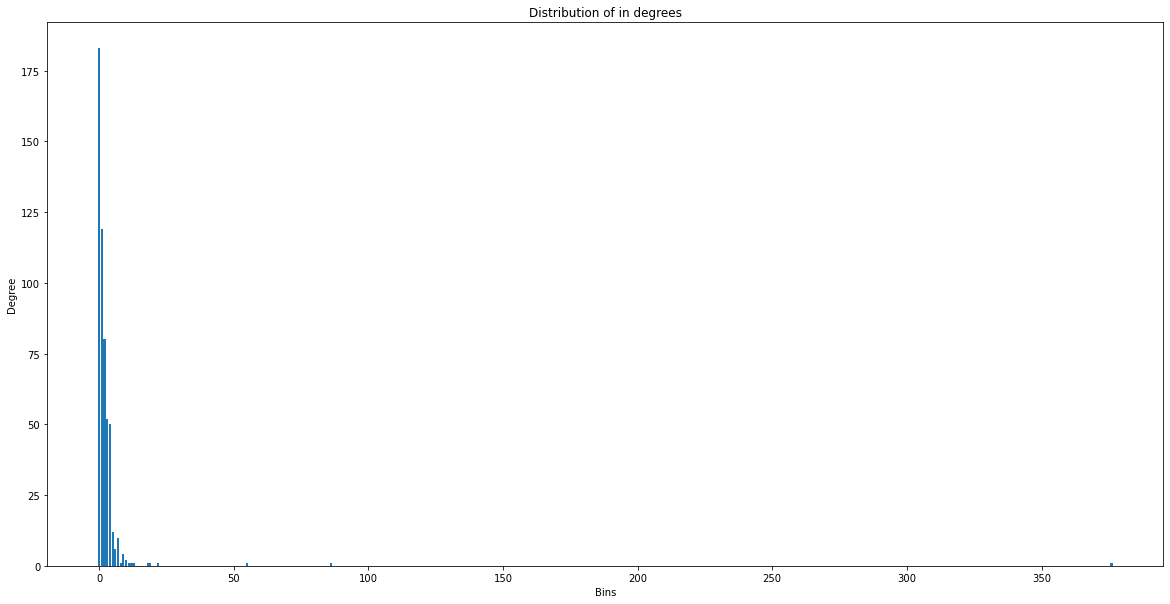

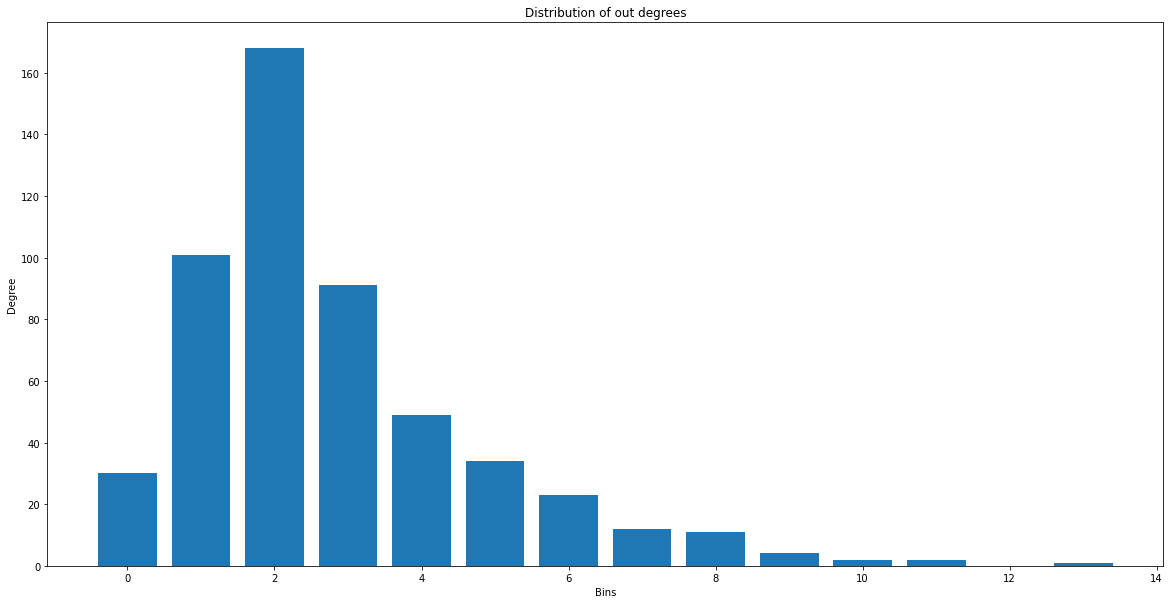

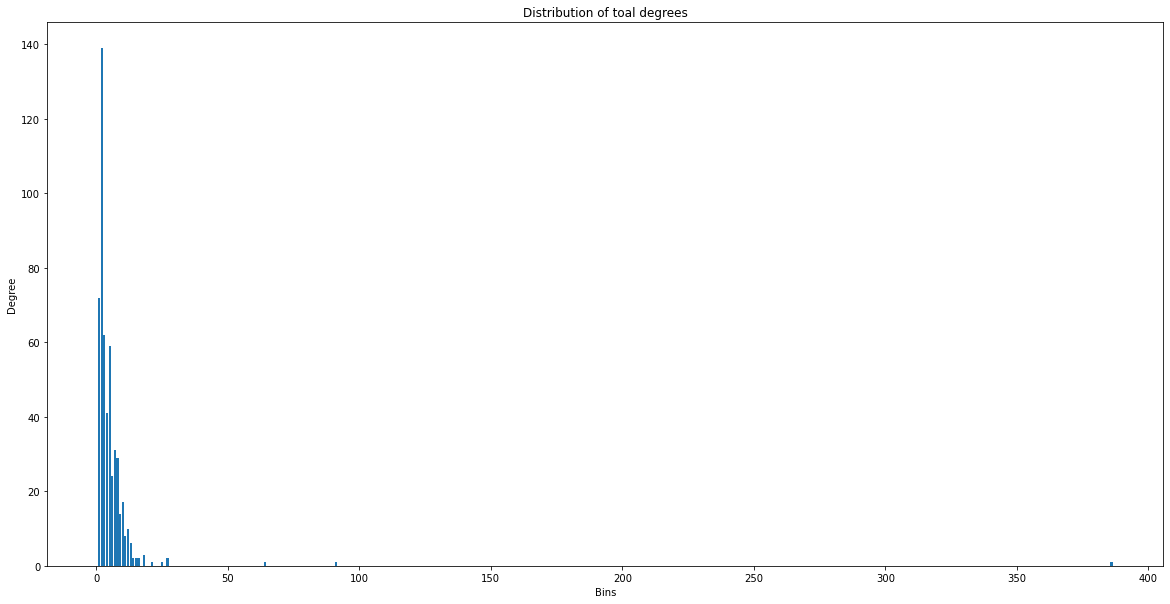

In [29]:
inDegree = [gcc.in_degree(node) for node in gcc.nodes()]
outDegree = [gcc.out_degree(node) for node in gcc.nodes()]
totalDegree = [gcc.degree(node) for node in gcc.nodes()]

maxIn = max(inDegree,key=lambda item:item)
maxOut = max(outDegree,key=lambda item:item)
maxTotal = max(totalDegree,key=lambda item:item)

minIn = min(inDegree,key=lambda item:item)
minOut = min(outDegree,key=lambda item:item)
minTotal = min(totalDegree,key=lambda item:item)

vIn = np.linspace(minIn, maxIn, maxIn-minIn+1)
counts, vIn = np.histogram(inDegree, vIn)
plt.figure(figsize=(20,10))
plt.bar(vIn[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of in degrees')

vOut = np.linspace(minOut, maxOut, maxOut-minOut+1)
counts, vOut = np.histogram(outDegree, vOut)
plt.figure(figsize=(20,10))
plt.bar(vOut[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of out degrees')

vTotal = np.linspace(minTotal, maxTotal, maxTotal-minTotal+1)
counts, vTotal = np.histogram(totalDegree, vTotal)
plt.figure(figsize=(20,10))
plt.bar(vTotal[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of toal degrees')


plt.show()

What we can see from these degree distributions is that the out-degree is much more evenly disrtibuted than the in degree. This would suggest that every character's page has a similar amount of hyperlinks. The in-degree distribution is not even at all. The vast majority of nodes have a few in-edges as can be seen in the distribution. There are a few nodes (characters) with a very high degree of in-edges. We suspect that these are the main characters in the game (e.g. Link), so a large number of minor characters refrence them in their wiki-page.

- Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. What does it say about our network?

In [30]:
#TODO

- Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.

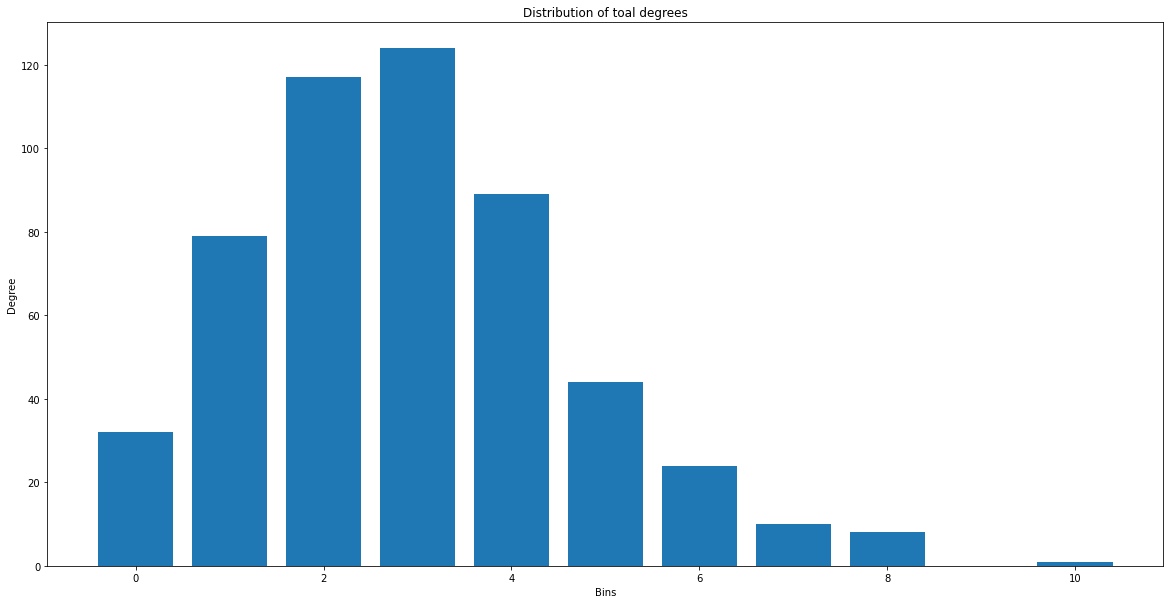

In [31]:
n = gcc.number_of_nodes()
k = gcc.number_of_edges()/ gcc.number_of_nodes()
p = k/(n-1)
gnp = nx.fast_gnp_random_graph(n,p)

degreeGnp = [gnp.degree(node) for node in gnp.nodes()]
maxGnp = max(degreeGnp,key=lambda item:item)
minGnp = min(degreeGnp,key=lambda item:item)

vGnp = np.linspace(minGnp, maxGnp, maxGnp-minGnp+1)
countsGnp, vGnp = np.histogram(degreeGnp, vGnp)
plt.figure(figsize=(20,10))
plt.bar(vGnp[:-1], countsGnp)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of toal degrees')
plt.show()

Since the random network (Gnp) is undirected, we can only compare it's degree distribution to the total degree distribution of our Zelda network. We can see that the average degree in the random network is much more evenly distributed than the Zelda network. Since the network is created at random, it is very unlikely that it would have a distribution similar to the Zelda network, where the majority of nodes have only one edge and a single node has around 400 edges, as we see in the Zelda network. The distribution of the random networks resembles a normal distribution.

### Exercise 1b: Visualization

* <font color='darkblue'>
    Create a nice visualization of the total (undirected) network:
</font>
* <font color='darkblue'>
    Color nodes according to the role;
</font>
* <font color='darkblue'>
    Scale node-size according to degree;
</font>
* <font color='darkblue'>
    Get node positions based on the Force Atlas 2 algorithm;
</font>
* <font color='darkblue'>
    Whatever else you feel like that would make the visualization nicer.
</font>

* <font color='darkblue'>
    Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?
</font>

## Part 2: Word-clouds

* <font color='darkblue'>
    Create a word-cloud for each race of the five champions of Hyrule (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.
</font>

In [145]:
#Create the corpus
corpus_root = 'cleanFiles'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

In [150]:
df_characters = pd.read_csv('Zelda.csv')

In [151]:
for index, row in df_characters.iterrows():
    row['Name'] = row['Name'].replace(" ", "_")
names = df_characters.Name.values.tolist()

In [183]:
#CLEANING THE TEXT FILES

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
wnl = nltk.WordNetLemmatizer()

more_stopwords = {'character', 'zelda', 'wild', '='}
stop_words = stop_words.union(more_stopwords)

for name in names:
    file1 = open("txt files/" + name + ".txt")
    theText = file1.read()

    # Regex
    theText = re.sub('==.*?==', '', theText)

    # Remove every name from every text file
    for test in names:
        theText = re.sub(test, '', theText)

    # Removing punctuations
    words = tokenizer.tokenize(theText)

    for r in words:
        #Setting to lowercase
        r = r.lower()

        if not r in stop_words:
            appendFile = open("cleanFiles/" + name + ".txt",'a')
            appendFile.write(" "+r)
            appendFile.close()

        # Lemmatization
        r = wnl.lemmatize(r)

In [153]:
# Create dataframes for each Race
df_Hylian = df_characters.loc[(df_characters['Race'] == 'Hylian')]
df_Zora = df_characters.loc[(df_characters['Race'] == 'Zora')]
df_Goron = df_characters.loc[(df_characters['Race'] == 'Goron')]
df_Gerudo = df_characters.loc[(df_characters['Race'] == 'Gerudo')]
df_Rito = df_characters.loc[(df_characters['Race'] == 'Rito')]

In [154]:
# Extract the names from the dataframes for future use
hylians = df_Hylian.Name.values
zoras = df_Zora.Name.values
gorons = df_Goron.Name.values
gerudos = df_Gerudo.Name.values
ritos = df_Rito.Name.values

In [155]:
# Calculate TC-IDF ranking
def calcRate(namesInRace):
    wordsInRace = defaultdict(list)
    appearsInCorpus = defaultdict(list)
    
    for name in namesInRace:
        theText = nltk.Text(newcorpus.words(name + '.txt'))
        fdist = FreqDist(theText)
        
        for word in fdist:
            wordTC = fdist[word]
                
            wordsInRace[word].append(wordTC)
            appearsInCorpus[word].append(name)
    
    superstring = ""
    for key, value in wordsInRace.items():
        TC = sum(value)
        IDF = math.log(len(namesInRace) / len(appearsInCorpus[key]))

        TCIDF = math.ceil(TC*IDF)
        
        superstring += (key + " ") * TCIDF

    return superstring

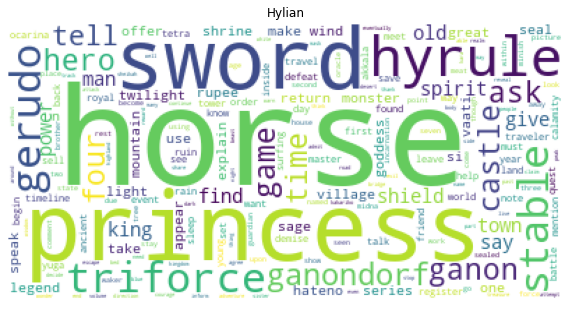

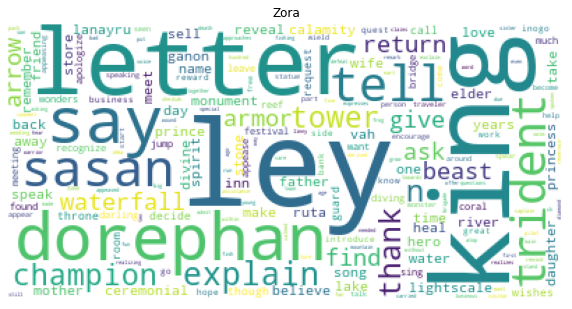

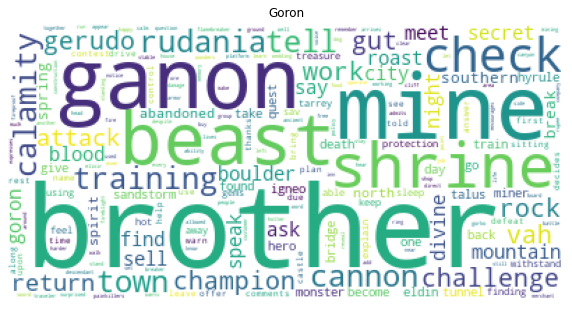

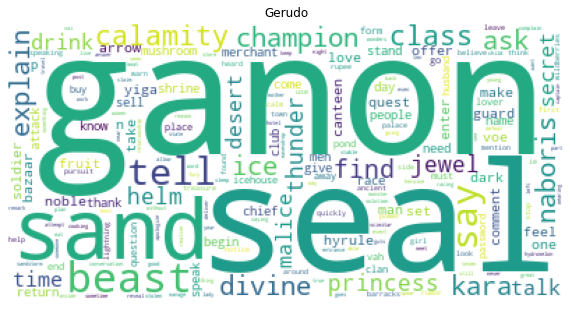

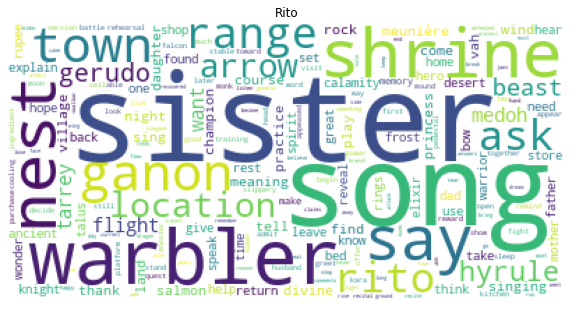

In [184]:
hyliansCloud = calcRate(hylians)
zorasCloud = calcRate(zoras)
goronsCloud = calcRate(gorons)
gerudosCloud = calcRate(gerudos)
ritosCloud = calcRate(ritos)

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(hyliansCloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Hylian")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(zorasCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Zora")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(goronsCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Goron")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(gerudosCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Gerudo")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(ritosCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Rito")
plt.show()

## Part 3: Communities and TF-IDF

<font color='darkblue'>
    Find communities and compute their associated TF-IDF
</font>

* <font color='darkblue'>
    Explain the Louvain algorithm and how it finds communities in a newtork.
</font>

* <font color='darkblue'>
    Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works)
</font>

* <font color='darkblue'>
    Comment your results:
</font>
* <font color='darkblue'>
    How many communities did you find in total?
</font>
* <font color='darkblue'>
    Compute the value of modularity with the partition created by the algorithm.
</font>
* <font color='darkblue'>
    Plot the distribution of community sizes.
</font>

* <font color='darkblue'>
    For the 5 largest communities, create TF-IDF based rankings of words in each community.
</font>
* <font color='darkblue'>
    There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
</font>
* <font color='darkblue'>
    List the 5 top words for each community according to TF.
</font>
* <font color='darkblue'>
    List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.
</font>

## Part 4: Sentiment of communities

<font color='darkblue'>
    Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.
</font>
<font color='darkblue'>
    A couple of additional instructions you will need below:
</font>
* <font color='darkblue'>
    We name each community by its three most connected characters.
</font>
* <font color='darkblue'>
    Average the average sentiment of the nodes in each community to find a community level sentiment.
</font>

<font color='darkblue'>
    Here's what you need to do (repeat these steps and report your results for both LabMT and VADER):
</font>

* <font color='darkblue'>
    Calculate and store sentiment for every character
</font>

* <font color='darkblue'>
    Create a histogram of all character's associated sentiments.
</font>

* <font color='darkblue'>
    What are the 10 characters with happiest and saddest pages?
</font>

<font color='darkblue'>
    Now, compute the sentiment of communities:
</font>

* <font color='darkblue'>
    What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
</font>

* <font color='darkblue'>
    What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
</font>

* <font color='darkblue'>
    Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.
</font>

* <font color='darkblue'>
    Explain the difference between the two methods and compare the results you have obtained above.
</font>

* <font color='darkblue'>
    What is the advantage of using a rule-based method over the dictionary-based approach?
</font>